In [15]:
#!pip install earthengine-api

import ee
import geemap

ee.Initialize()

In [10]:
import pandas as pd

data = pd.read_csv("Cayuga_Lake_org.csv", index_col=0, parse_dates=True)

In [13]:
data.info()
data.head()
data.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140 entries, 2019-06-04 to 2022-09-28
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ChA     140 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


,ChA
date,
2019-06-04,15.671
2019-06-17,7.207
2019-06-18,9.575
2019-06-18,19.168
2019-06-23,13.178


In [108]:
import geemap

# Station coordinates
station = ee.Geometry.Point(-76.5975, 42.55517)

# Initialize the Map
Map = geemap.Map()

# Add the station point to the map
Map.addLayer(station)

# Center the map on the station point with a specified zoom level
Map.centerObject(station, 16)
Map

Map(center=[42.55517, -76.5975], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(c…

In [110]:
# Define the bands to select and their corresponding names
S2_BANDS = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
STD_NAMES = ['blue', 'green', 'Red', 'RedEdge1', 'RedEdge2', 'RedEdge3', 'NIR', 'RedEdge4', 'SWIR1', 'SWIR2']

In [111]:
def maskS2sr(image):
    # Cloud mask
    cloudMask = image.select('QA60').bitwiseAnd(int('1111111000000000', 2)).eq(0)

    # Cloud shadow mask
    cloudShadowMask = image.select('QA60').bitwiseAnd(int('0000000111000000', 2)).eq(0)

    # Snow/ice mask
    snowMask = image.select('QA60').bitwiseAnd(int('0000000000011000', 2)).eq(0)

    # Water mask
    nlcd = ee.Image('USGS/NLCD/NLCD2016')
    waterMask = nlcd.select('landcover').eq(11)

    # Apply the cloud, cloud shadow, snow/ice, and water masks
    correctedImage = image.updateMask(cloudMask).updateMask(cloudShadowMask).updateMask(snowMask).updateMask(waterMask)

    return correctedImage

In [112]:
# Normalized difference chlorophyll index 
def ndci(img):
    ndci = img.expression("(B5 - B4) / (B5 + B4)", {
        'B4': img.select('B4'),  # 'B4' corresponds to red-edge
        'B5': img.select('B5'),  # 'B5' corresponds to red-edge (longer wavelength)
    }).rename("NDCI")

    return img.addBands([ndci])

# # Normalized difference water index 
# def ndci(img):
#     ndci = img.expression("(B3 - B8) / (B3 + B8)", {
#         'B3': img.select('B3'),  # 'B3' corresponds to green
#         'B8': img.select('B8'),  # 'B8' corresponds to near-infrared (NIR)
#     }).rename("NDCI")

#     return img.addBands([ndci])

In [113]:
# Retrieve Sentinel-2 imagery
s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filter(ee.Filter.calendarRange(1, 12, 'month')) \
    .filter(ee.Filter.bounds(station)) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .filter(ee.Filter.date('2019-01-01', '2022-12-31')) \
    .map(maskS2sr) \
    .map(ndci)

In [114]:
# Define the function to calculate mean NDCI around the station
def station_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=station.buffer(45).bounds(), scale=10).get('NDCI')
    return ee.Feature(img.geometry()).set('date', img.date().format()).set('mean', mean)

# Apply the function to the Sentinel-2 imagery collection
station_reduced_imgs = s2.map(station_mean)

# Retrieve the computed values
nested_list = station_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date', 'mean']).values().get(0)

In [115]:
# Convert the computed values to a pandas DataFrame
df = pd.DataFrame(nested_list.getInfo(), columns=['date', 'mean'])

df

,date,mean
0,2019-03-20T16:11:20,-0.013416
1,2019-04-16T16:01:28,0.029879
2,2019-05-06T16:01:29,0.032314
3,2019-05-21T16:01:34,0.042141
4,2019-05-31T16:01:33,0.068135
...,...,...
105,2022-10-22T16:01:25,-0.001958
106,2022-11-04T16:11:20,-0.002363
107,2022-11-09T16:11:26,-0.008494
108,2022-12-21T16:01:24,-0.011209


In [116]:
df['date'] = pd.to_datetime(df['date'])

# Format 'date' column to exclude the time
df['date'] = df['date'].dt.date
df

,date,mean
0,2019-03-20,-0.013416
1,2019-04-16,0.029879
2,2019-05-06,0.032314
3,2019-05-21,0.042141
4,2019-05-31,0.068135
...,...,...
105,2022-10-22,-0.001958
106,2022-11-04,-0.002363
107,2022-11-09,-0.008494
108,2022-12-21,-0.011209


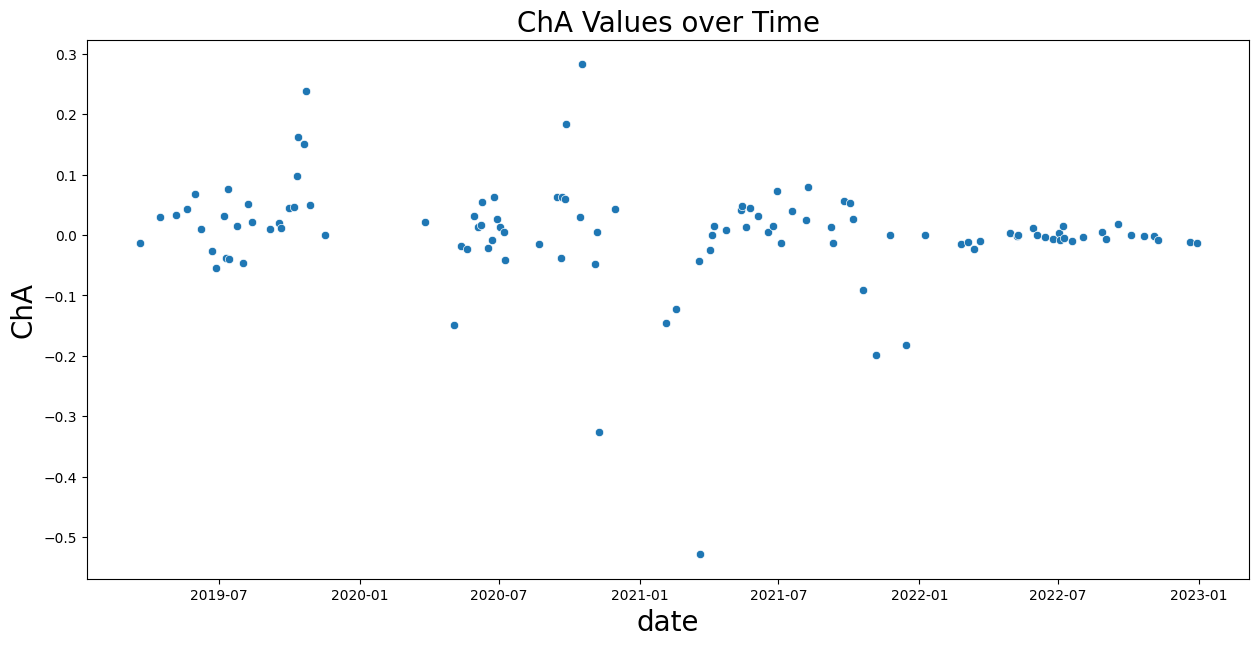

In [119]:
#!pip install seaborn

import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
# Create a figure with subplots and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15, 7))

# Create the plot by setting our dataframe to the data argument
sns.scatterplot(data=df, x='date', y='mean', ax=ax)

# Set the labels and title
ax.set_ylabel('ChA', fontsize=20)
ax.set_xlabel('date', fontsize=20)
ax.set_title('ChA Values over Time', fontsize=20)

# Format the x-axis tick labels to display only the year
# ax.xaxis.set_major_formatter(plt.FixedFormatter(df['date'].dt.year.unique()))

# Display the plot
plt.show()

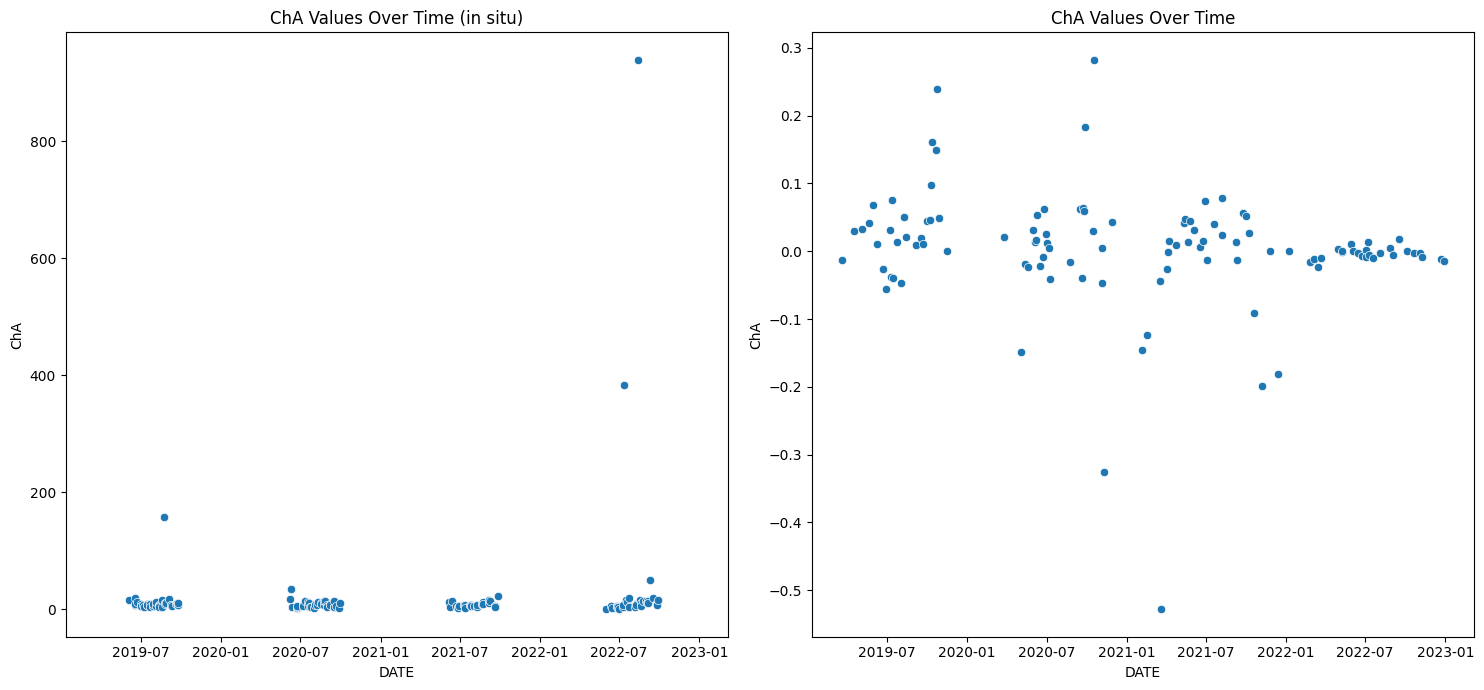

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), sharex=True)

# Seaborn scatter plot
sns.scatterplot(data=data, x='date', y='ChA', ax=ax1)
ax1.set_xlabel('DATE')
ax1.set_ylabel('ChA')
ax1.set_title('ChA Values Over Time (in situ)')

# Seaborn scatter plot
sns.scatterplot(data=df, x='date', y='mean', ax=ax2)
ax2.set_xlabel('DATE')
ax2.set_ylabel('ChA')
ax2.set_title('ChA Values Over Time')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

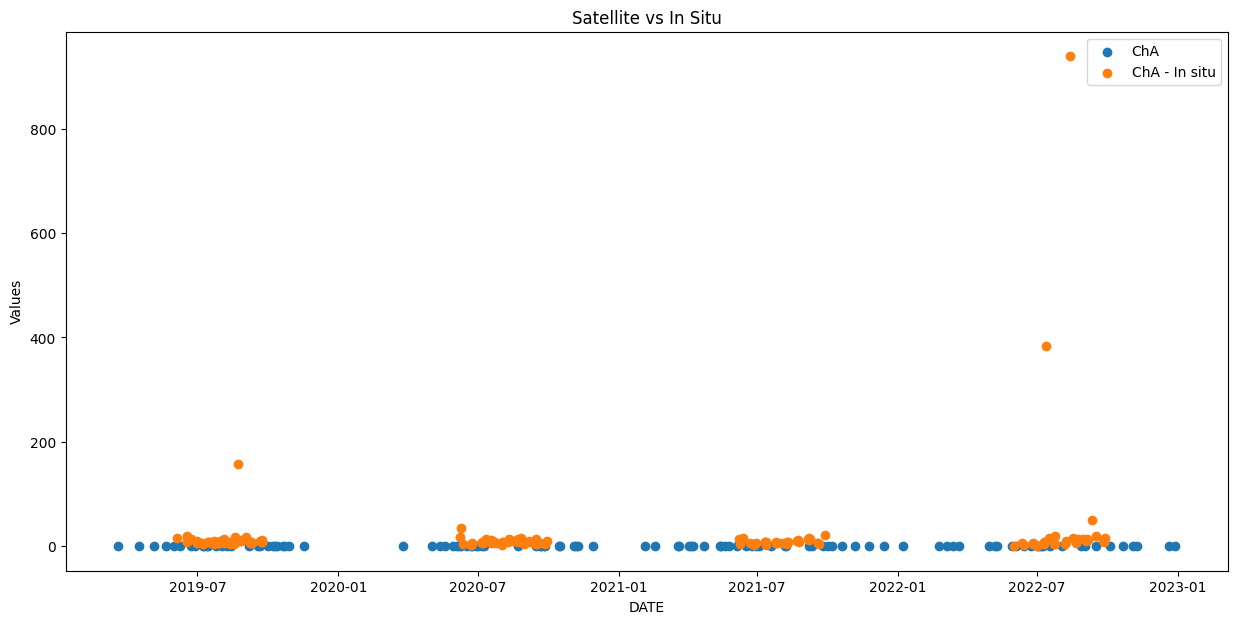

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Matplotlib scatter plot
ax.scatter(df['date'], df['mean'], label='ChA')

# Matplotlib scatter plot
ax.scatter(data.index, data['ChA'], label='ChA - In situ')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('Values')
ax.set_title('Satellite vs In Situ')

# Add a legend
ax.legend()

# Display the plot
plt.show()

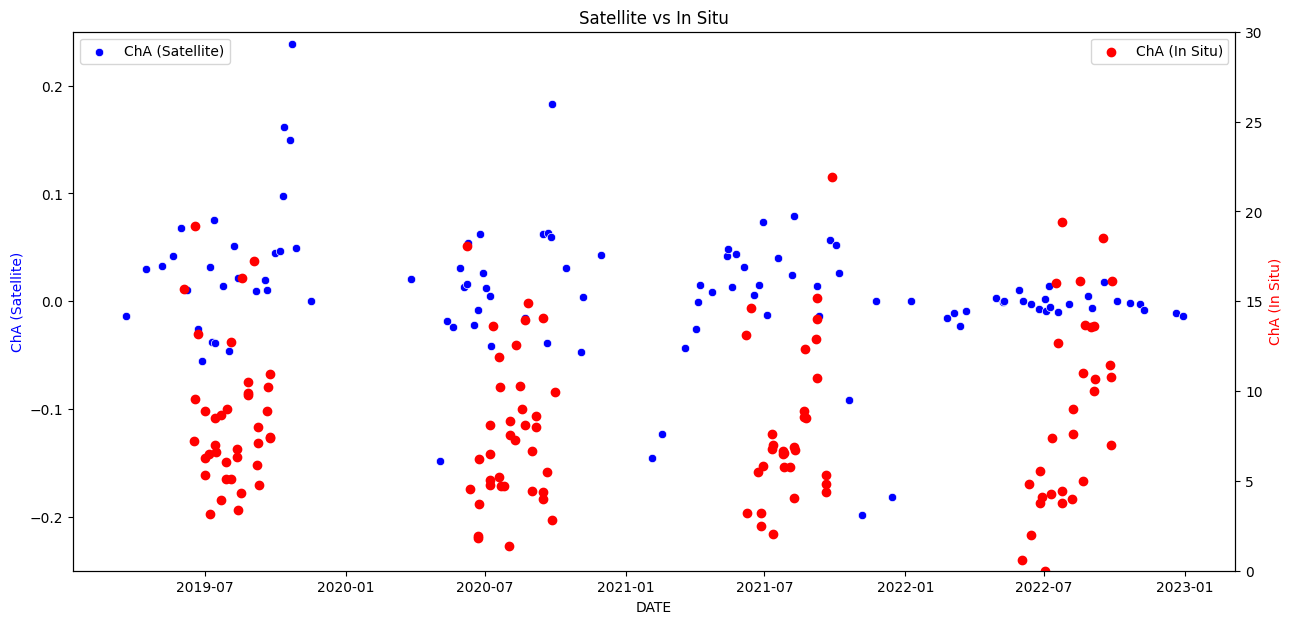

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and an Axes object
fig, ax = plt.subplots(figsize=(15, 7))

# Seaborn scatter plot for ChA in satellite imagery
sns.scatterplot(data=df, x='date', y='mean', ax=ax, label='ChA (Satellite)', color='blue')

# Create a twin Axes object for ChA in situ
ax2 = ax.twinx()

# Matplotlib scatter plot for ChA in situ
ax2.scatter(data.index, data['ChA'], label='ChA (In Situ)', color='red')

# Set the labels and title
ax.set_xlabel('DATE')
ax.set_ylabel('ChA (Satellite)', color='blue')
ax2.set_ylabel('ChA (In Situ)', color='red')
ax.set_title('Satellite vs In Situ')

# Set different ranges for the y-axes
ax.set_ylim(-0.25, 0.25)  
ax2.set_ylim(0, 30) 

# Add legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Display the plot
plt.show()